In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras import backend as K

## Notes

Adapted from https://github.com/dynamicslab/databook_python

In [2]:
def radbas(x):
    return tf.exp(-tf.math.pow(x,2))

In [3]:
Xin = np.load('inputs.npy')
Xout = np.load('outputs.npy')

In [4]:
Xin.shape, Xout.shape

((100, 8000, 3), (100, 8000, 3))

In [5]:
u = Xin[1:,...].reshape((-1,3))
v = Xout[1:,...].reshape((-1,3))

In [6]:
u.shape, v.shape

((792000, 3), (792000, 3))

In [7]:
with tf.device('/CPU:0'):
    input = Input(shape=u.shape[1:])
    x = Dense(20, activation='sigmoid')(input)
    x = Dense(20, activation=radbas)(x)
    x = Dense(20, activation='sigmoid')(x)
    output = Dense(3, activation='linear')(x)
    model = Model(inputs=[input], outputs=[output])

Metal device set to: AMD Radeon Pro 560X

systemMemory: 32.00 GB
maxCacheSize: 2.00 GB



2021-11-03 09:56:04.290028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 09:56:04.290706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-03 09:56:04.291051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
opt = Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)

In [9]:
with tf.device('/CPU:0'):
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mse']
    )

In [10]:
with tf.device('/CPU:0'):
    hist = model.fit(
        x=u,
        y=v,     
        epochs=1000,
        batch_size=2048,
        # validation_split=0.1,
        verbose=1)

2021-11-03 09:56:04.469027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
387/387 [==============================] - 1s 1ms/step - loss: 256.7062 - mse: 256.7062
Epoch 2/1000
387/387 [==============================] - 1s 2ms/step - loss: 235.2897 - mse: 235.2897
Epoch 3/1000
387/387 [==============================] - 1s 2ms/step - loss: 219.0386 - mse: 219.0386
Epoch 4/1000
387/387 [==============================] - 1s 2ms/step - loss: 206.9774 - mse: 206.9774
Epoch 5/1000
387/387 [==============================] - 1s 2ms/step - loss: 197.3202 - mse: 197.3202
Epoch 6/1000
387/387 [==============================] - 1s 2ms/step - loss: 189.1981 - mse: 189.1981
Epoch 7/1000
387/387 [==============================] - 1s 2ms/step - loss: 182.0546 - mse: 182.0546
Epoch 8/1000
387/387 [==============================] - 1s 2ms/step - loss: 175.4325 - mse: 175.4325
Epoch 9/1000
387/387 [==============================] - 1s 2ms/step - loss: 168.8851 - mse: 168.8851
Epoch 10/1000
387/387 [==============================] - 1s 2ms/step - loss: 162.1342 - mse

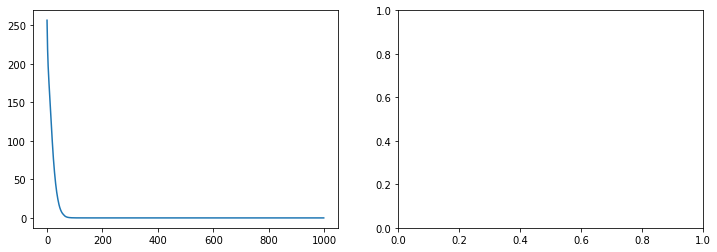

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(hist.history['mse'], label='mse')
# axes[1].plot(hist.history['val_mse'], label='val_mse', c='red')
pass

### In-sample predictions for all trajectories

In [12]:
n_reps, n_steps, n_dims = Xin.shape

predicted_trajectory = np.zeros((n_reps, n_steps, n_dims))
predicted_trajectory[:, 0, :] = Xin[:, 0, :]

with tf.device('/CPU:0'):
    for i in range(n_steps-1):
        predicted_trajectory[:, i+1] = model.predict(x=predicted_trajectory[:, i:(i+1), :].squeeze())

### Visualize predictions

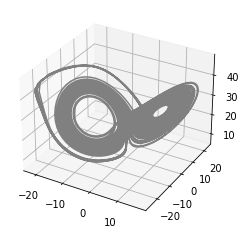

In [13]:
k = np.random.randint(1,100)

x, y, z = predicted_trajectory[k].T
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, 'gray')
pass

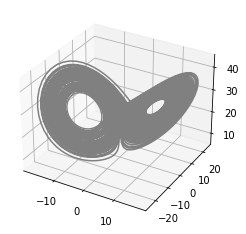

In [14]:
x, y, z = Xin[k,...].T
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, 'gray')
pass

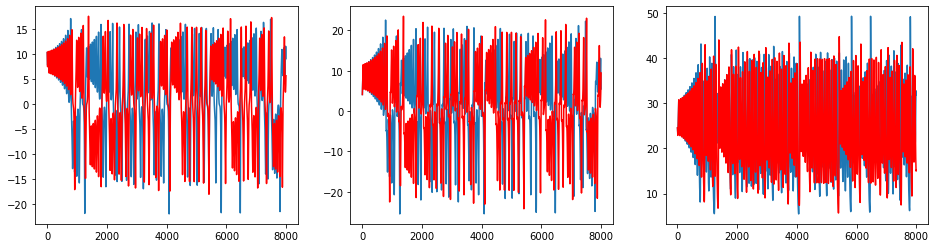

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

x, y, z = predicted_trajectory[k].T

axes[0].plot(x)
axes[0].plot(Xin[k,:,0], c='red')
axes[1].plot(y)
axes[1].plot(Xin[k,:,1], c='red')
axes[2].plot(z)
axes[2].plot(Xin[k,:,2], c='red')
pass

### Out-of-sample test

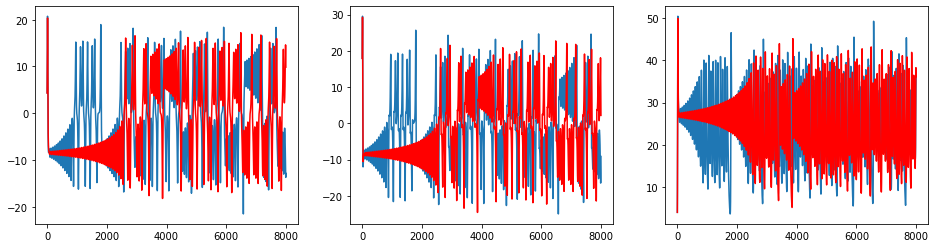

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

x, y, z = predicted_trajectory[0].T

axes[0].plot(x)
axes[0].plot(Xin[0,:,0], c='red')
axes[1].plot(y)
axes[1].plot(Xin[0,:,1], c='red')
axes[2].plot(z)
axes[2].plot(Xin[0,:,2], c='red')
pass